Investigate how different values of the boosting parameter 0 < ν < 1 influence the behavior of L2Boost.
1. Generate a synthetic dataset with n = 1000 samples and p= 20 features. Ensure that the features have varying degrees of correlation.
2. Run L2Boost with different values of ν keeping the number of steps fixed (e.g., 500 iterations).
3. Track and record which coordinates are selected at each iteration. Create a plot showing the selection frequency of each coordinate over the boosting iterations for different values of ν.

nu= 1.0: final train MSE=0.9656 | final test MSE=1.1701
nu= 0.5: final train MSE=0.9656 | final test MSE=1.1701
nu= 0.1: final train MSE=0.9698 | final test MSE=1.1606
nu=0.01: final train MSE=3.1360 | final test MSE=3.3385


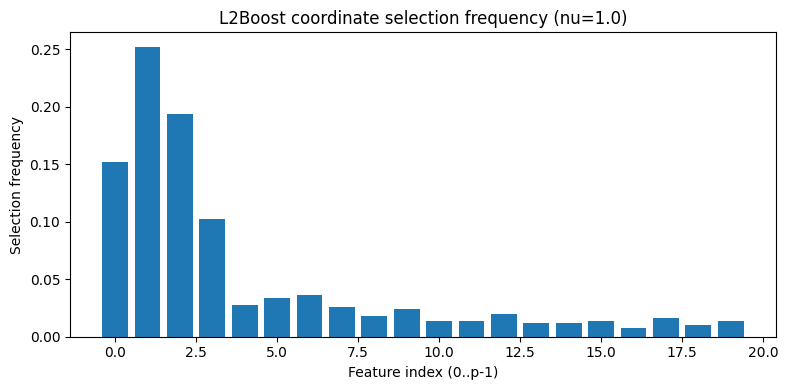

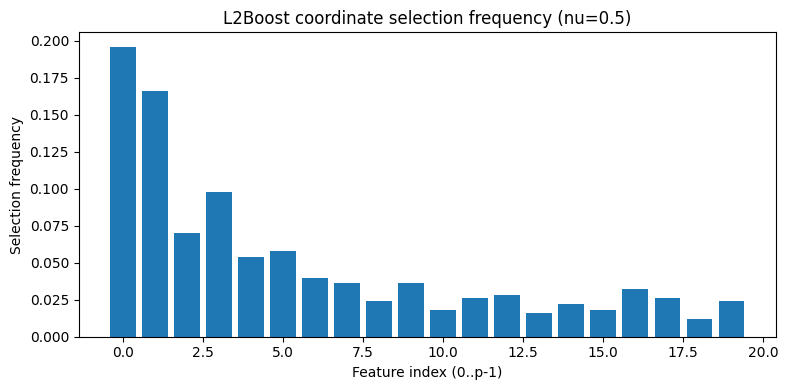

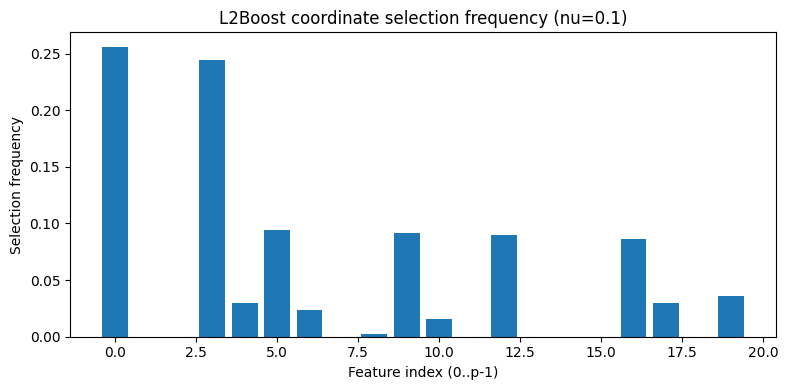

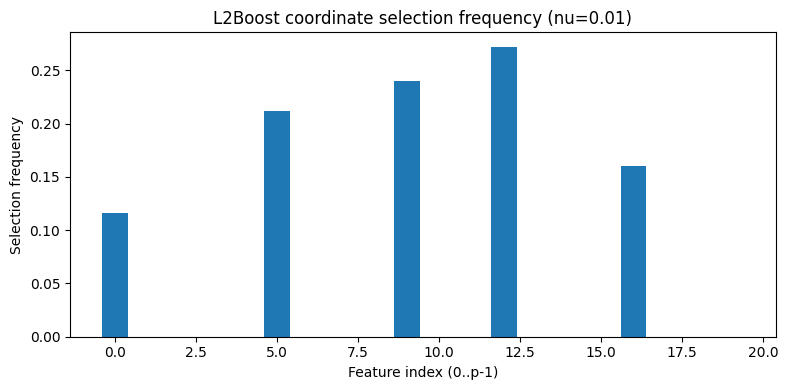

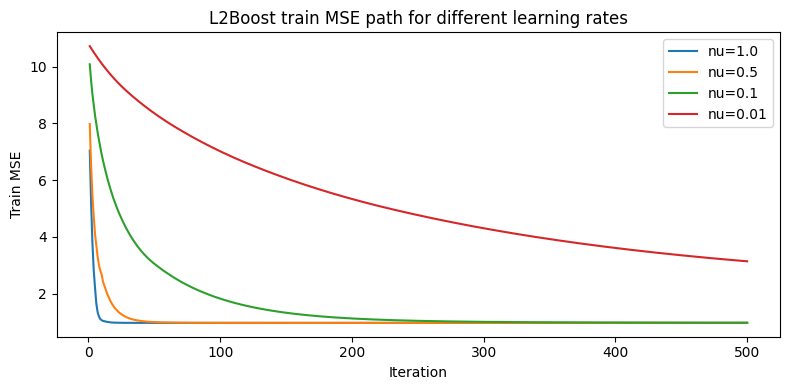

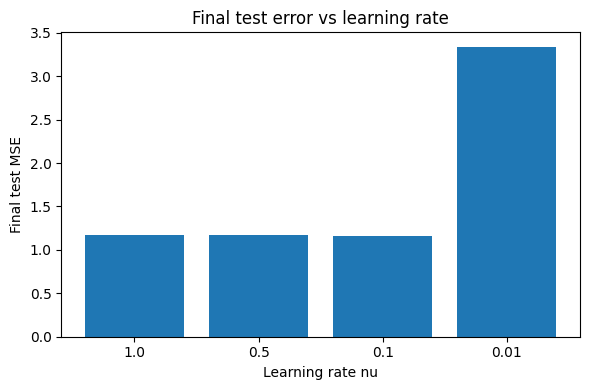

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

rng = np.random.default_rng(123)

# 1) Correlated synthetic data

def make_correlated_data(n=1000, p=20, noise_sigma=1.0, seed=123):
    """
    5 blocks (size 4 each) with rhos = [0.9, 0.6, 0.3, 0.1, 0.0].
    True beta is sparse.
    """
    rng = np.random.default_rng(seed)
    block_size = p // 5
    rhos = [0.9, 0.6, 0.3, 0.1, 0.0]

    Sig_blocks = []
    for rho in rhos:
        B = rho ** np.abs(np.subtract.outer(np.arange(block_size), np.arange(block_size)))
        Sig_blocks.append(B)
    Sigma = np.block([[Sig_blocks[i] if i==j else np.zeros((block_size, block_size))
                       for j in range(5)] for i in range(5)])

    X = rng.multivariate_normal(mean=np.zeros(p), cov=Sigma, size=n)

    beta = np.zeros(p)
    beta[[0, 3, 5, 9, 12, 16]] = [2.0, -1.6, 1.2, 1.5, -1.8, 1.0]
    y = X @ beta + rng.normal(0.0, noise_sigma, size=n)

    # split
    ntr = int(0.7 * n)
    perm = rng.permutation(n)
    tr, te = perm[:ntr], perm[ntr:]
    Xtr, Xte, ytr, yte = X[tr], X[te], y[tr], y[te]

    # standardize X (train stats) and center y (removes intercept need)
    mu, sd = Xtr.mean(0), Xtr.std(0, ddof=0)
    sd[sd == 0] = 1.0
    Xtr = (Xtr - mu) / sd
    Xte = (Xte - mu) / sd
    ytr = ytr - ytr.mean()
    yte = yte - ytr.mean()  # center test by train mean for fair MSE

    return Xtr, ytr, Xte, yte, beta

# 2) L2Boost with parametric learners

def l2boost_parametric(X, y, M=500, nu=0.1):
    """
    Each round choose coordinate k that best least-squares-fits residuals r.
    Closed-form β_k = (x_k^T r)/(x_k^T x_k).
    Update: F += nu * β_k * x_k.
    """
    n, p = X.shape
    F = np.zeros(n)
    coords = []
    betas = []
    mse_path = []

    # Precompute column norms for efficiency
    col_den = np.sum(X * X, axis=0) + 1e-12

    for m in range(M):
        r = y - F
        # scores for each coordinate = improvement if we fit along x_k
        # argmax over (x_k^T r)^2 / (x_k^T x_k)
        numer = X.T @ r            # length p
        k = int(np.argmax((numer * numer) / col_den))
        beta_k = numer[k] / col_den[k]
        step = nu * beta_k

        F = F + step * X[:, k]
        coords.append(k)
        betas.append(step)
        mse_path.append(np.mean((y - F) ** 2))

    return np.array(coords), np.array(betas), np.array(mse_path)

def apply_path(X, coords, betas):
    """Apply learned path (coords, betas) to new X to get predictions."""
    F = np.zeros(X.shape[0])
    for k, b in zip(coords, betas):
        F += b * X[:, k]
    return F

# 3) Run for multiple learning rates ν

Xtr, ytr, Xte, yte, beta_true = make_correlated_data()

nus = [1.0, 0.5, 0.1, 0.01]
results = {}

M = 500
for nu in nus:
    coords, betas, mse_tr = l2boost_parametric(Xtr, ytr, M=M, nu=nu)
    Fte = apply_path(Xte, coords, betas)
    mse_te = np.mean((yte - Fte) ** 2)
    results[nu] = {
        "coords": coords,
        "betas": betas,
        "mse_tr": mse_tr,
        "mse_te": mse_te
    }
    print(f"nu={nu:>4}: final train MSE={mse_tr[-1]:.4f} | final test MSE={mse_te:.4f}")

# 4) Plots

# (A) Selection frequency per feature for each nu
for nu in nus:
    coords = results[nu]["coords"]
    counts = Counter(coords)
    idx = np.arange(Xtr.shape[1])
    freq = np.array([counts.get(i, 0) for i in idx]) / len(coords)  # frequency

    plt.figure(figsize=(8,4))
    plt.bar(idx, freq)
    plt.xlabel("Feature index (0..p-1)")
    plt.ylabel("Selection frequency")
    plt.title(f"L2Boost coordinate selection frequency (nu={nu})")
    plt.tight_layout()
    plt.show()

# (B) Train MSE vs iterations for different nu
plt.figure(figsize=(8,4))
for nu in nus:
    plt.plot(np.arange(1, M+1), results[nu]["mse_tr"], label=f"nu={nu}")
plt.xlabel("Iteration")
plt.ylabel("Train MSE")
plt.title("L2Boost train MSE path for different learning rates")
plt.legend()
plt.tight_layout()
plt.show()

# (C) Test MSE at the final iteration (simple bar plot)
plt.figure(figsize=(6,4))
bars = [results[nu]["mse_te"] for nu in nus]
labels = [f"{nu}" for nu in nus]
plt.bar(labels, bars)
plt.xlabel("Learning rate nu")
plt.ylabel("Final test MSE")
plt.title("Final test error vs learning rate")
plt.tight_layout()
plt.show()

The learning rate nu controls:
1. Step size/“boosting time”. Training loss decays roughly exponentially with the product m*ν (continuous-time view: as ν tends to 0 and mν tends to t, the path follows an ODE). Hence different ν values with the same mν give similar training loss, but generalization depends on the full path.
2. Regularization via early stopping.
	•	Larger ν: rapid loss decrease, there are few steps to interpolate, higher variance and earlier overfit.
	•	Smaller ν: slow, smooth path, needs more rounds, stronger shrinkage and typically better test error for a fixed number of steps. Early stopping index m is the regularization parameter.
3. Degrees of freedom (linear boosting). With linear base learners, the fitted values evolve under a linear smoothing operator. Effective df grows with iterations and roughly scales with mν; small ν grows df more slowly hence less variance inflation per step.